In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft2, ifft, fftshift, ifftshift
import librosa
import spkit as sp
import IPython
from scipy.signal import stft, istft
import soundfile as sf

# This is not completed but here for the sake of saving progress

Basically, to be able to recover the original signal from phase,
 we use the following equation:
 

![title](ss1.png)


While having in mind this ambiguity function:


![title](ss2.png)


However the problem is that A_g on the denominator is so small for some values, hence unstable. 
Goal is to use multiple window STFTs in a row so that they overlap and estimate one overall good window function.

One possible (the first) proposition as a solution: using gaussian window functions. Their ambiguity functions are normally circular, however as we said they decay asap as we go further from (0,0). Hence the solution is to shift them (to be elaborated) and though their shapes become eliptic, when you overlap a good ennough deal of these, you see the bisectrice of those summing up and hence you get a ciruclar (kinda) dense area with the big values we need all the while estimating the one "g" original window. hence recovery

# note to myself, if have the time (not rn but during the week ofc, show gaussian functions, their ambiguity and how ϕ_js ambiguity is a rotation in ambiguity and (thus stft) because of its construction by definition (frft etc)


 first I'd like to remove phase of a audio to see how different this is.

In [6]:
y, sr = librosa.load('short_ladygaga_telephone.mp3', sr=None)  
D = librosa.stft(y, n_fft=1024, hop_length=512, window='hann')
magnitude = np.abs(D)
reconstructed2 = librosa.istft(magnitude**2, 
                              hop_length=512, 
                              window='hann', 
                              length=len(y))
sf.write('magnitude_square.mp3', reconstructed2, sr)

In [8]:
def autocorr_direct(y, max_size=None):
    y = np.asarray(y, dtype=float)
    N = y.shape[0]
    
    # Full (length 2N–1) correlation
    full_corr = np.correlate(y, y, mode='full')
    
    # Center index corresponds to lag=0
    mid = N - 1
    
    # Default max_size = N
    if max_size is None:
        max_size = N
    
    # Take lags [0..max_size-1]
    return full_corr[mid : mid + max_size]

r_direct = autocorr_direct(y, max_size=None)

sf.write('fft_and_ifft.mp3', r_direct, sr)


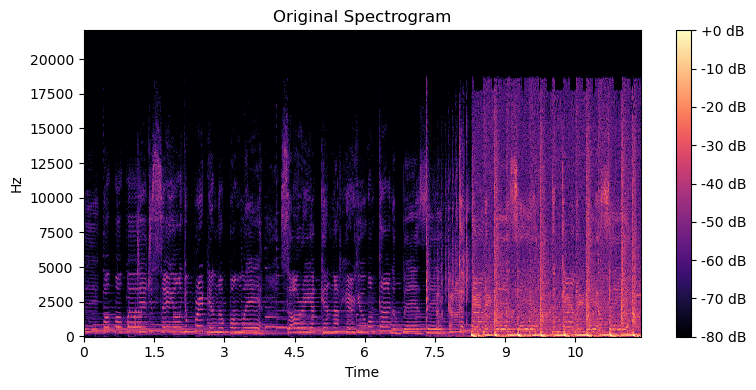

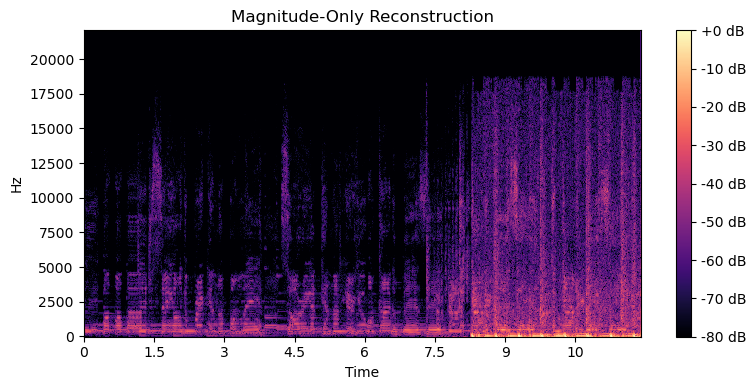

In [119]:
S_orig = librosa.amplitude_to_db(np.abs(D), ref=np.max)

D_rec = librosa.stft(reconstructed, n_fft=1024, hop_length=512, window='hann')
S_rec  = librosa.amplitude_to_db(np.abs(D_rec), ref=np.max)

# 2) Plot original
plt.figure(figsize=(8,4))
librosa.display.specshow(
    S_orig,
    sr=sr,
    hop_length=512,
    x_axis='time',
    y_axis='hz'
)
plt.title('Original Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

# 3) Plot magnitude-only reconstruction
plt.figure(figsize=(8,4))
librosa.display.specshow(
    S_rec,
    sr=sr,
    hop_length=512,
    x_axis='time',
    y_axis='hz'
)
plt.title('Magnitude-Only Reconstruction')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.show()

In [ ]:
print("here is the og sound (1st) and the only magnitude sound (2nd)")
IPython.display.display(IPython.display.Audio("short_ladygaga_telephone.mp3"))
IPython.display.display(IPython.display.Audio("magnitude_only.mp3"))

# calculate the autocorrelation of the signal and it should be that ?

here is the og sound (1st) and the only magnitude sound (2nd)


Thus we will show the utility and a demonstration of the following algorithm (the first algo suggested) to get familiar with what's happening :


![title](ss3.png)




In [186]:
def discrete_stft(f_samples, g_samples, Δt, a, M): # according to the papers 4.1
    """
    Compute V_g f(x_k, y_m) via the left‐Riemann sum in (4.1).
    
    Inputs:
      f    : real 1D array of length L
      g    : 1D window array of same length L (periodic)
      Δt   : sampling interval in time
      a    : integer time‐stride factor (so K = L // a shifts)
      M    : number of frequency bins
      
    Returns:
      c    : complex array of shape (M, K) with
             c[m,k] ≈ V_g f(x_k, y_m)
    """
    L = len(f_samples)
    
    # time‐shifts x_k = -T + k * Δt , but in samples that's just k·a
    m = np.arange(M)
    y = (1/Δt) * (-0.5 + m/M) # frequency between -1/2fs and 1/2fs
    
    # pre‐compute time samples t_l = -T + l·Δt
    # If f[0] corresponds to t = -T, then
    # t_l = -T + l·Δt  and T = L·Δt/2
    T = L*Δt//2 # this was decided already in the main function
    l = np.arange(L,dtype=int)
    t = -T + l*Δt # same as the way it was calculated everywhere, centered in -L/2 , L/2
    
    # prepare output   
    K = int(L//a) # no of shifts
    c = np.zeros((M, K), dtype=complex)
    exp_mat = np.exp(-2j * np.pi * np.outer(t, y))  # shape (L, M)

    x_shifts = -T + np.arange(K) * (a * Δt)
    
    # for each time‐shift k
    for k in range(K):
        # compute the window g shifted by k·a samples, with periodic wrap
        # index shift = l - k·a + L//2 per eqn (4.2)
        shift = (l - k*a + L//2) % L
        g_shifted = g_samples[shift]
        
        # pointwise product f_l * g_{l−ka+L/2}
        fg = f_samples * g_shifted
        
        # for each frequency bin m, sum fg_l * exp(-2πi * t_l * y_m)
        # we can vectorize across m by doing an outer product in the exponent
        #   exponent matrix shape (L, M)
      
        
        # Riemann sum: Δt * sum_l  f_l g_shifted_l  * exp(...)
        c[:, k] = Δt * (fg[:, None] * exp_mat).sum(axis=0)
    
    return c, x_shifts, y

In [ ]:
def sample_gauss_function(a, L, Δt):
    """Sampling φ₀(t) = a^{1/4} e^{-π a t²} on a uniform grid."""
    t = (np.arange(L) - L//2) * Δt
    return a**(1/4)*np.exp(-(t**2)*a*np.pi),t


def sample_gauss_ambiguity(a, X, Y):
    """
    Sample the base Gaussian ambiguity A₀(x,y) on grids X,Y.
    the Gauss function defined as : a**(1/4)*np.exp(-(x**2)*a*np.pi) 
    :param a: the x-axis stretch (dilation) factor a
    :return: the gaussian 'a' parametered function's ambiguity function
    """
    return 1/np.sqrt(2)* np.exp(-np.pi / 2 * (a*X**2 + 1/a*Y**2))
    
def rotated_gauss_ambiguity(a, alpha, X, Y):
    """
    Sample A_{FrFTₐ(φ₀)}(x,y) by rotating the (X,Y) grid.
    
    :param a: dilation factor of the base Gaussian
    :param alpha: rotation angle in radians
    :return: function A_phi(x,y)
    """
    ca, sa = np.cos(alpha), np.sin(alpha)
    Xr =  X*ca + Y*sa
    Yr = -X*sa + Y*ca
    return sample_gauss_ambiguity(a, Xr, Yr)
    
def rotate(function, alpha, X, Y):
    """
    Sample A_{FrFTₐ(φ₀)}(x,y) by rotating the (X,Y) grid.
    
    :param a: dilation factor of the base Gaussian
    :param alpha: rotation angle in radians
    :return: function A_phi(x,y)
    """
    ca, sa = np.cos(alpha), np.sin(alpha)
    Xr =  X*ca + Y*sa
    Yr = -X*sa + Y*ca
    return function(Xr, Yr)


In [ ]:
# ------------------------------------------------------------------------------------------
# parameters : 
a        = 5           # its the gaussian dilation
delta_t  = 0.001          # sampling interval
T        = 10.0           # its the half-window length in seconds
L        = int(2*T/delta_t) # amount of samples basically
M        = 129           # = no of frequency bins in STFT
N        = 5             # no of different windows
angles = np.pi * np.arange(1, N+1) / N
orders = 2 * angles / np.pi
# ------------------- regard to NOTE 4 ---------------------------------------------------


g_samples, t = sample_gauss_function(a, L, delta_t)
f_samples = np.sin(2*np.pi*t*50)


assert L == len(f_samples)
#------------- build FrFT-rotated windows --------------------
#phi = [sp.frft(g_samples, alpha=v) for v in orders] # φ_j basically :)
# ----------------- the magnitude only STFTs ---------------------
#    V[j] has shape (M, K) where K = L//a
V = []
stft_time = []
stft_frequency = []
for phi_j in phi:
    v,t,f = discrete_stft(f_samples, phi_j, delta_t, a, M)
    V.append(np.abs(v))
    stft_time.append(t)
    stft_frequency.append(f)

#

stft_time= stft_time[0]
stft_frequency= stft_frequency[0]

# defining STFT grid for ambiguity function:
#K = L // a
K = V[0].shape[1]  

k = np.arange(K) - (K-1)/2
m = np.arange(M)           - (M-1)/2

x = k * (a*delta_t)              # delay axis, x = -T + k * (a * delta_t)  # shape (K,)
y = m * (1/(M*delta_t))          # Doppler axis, y = (1/delta_t) * (-0.5 + m / M) # shape (M,)



def at_xy(data: np.ndarray,
          x0: float,
          y0: float,
          x_grid: np.ndarray = x,
          y_grid: np.ndarray = y) -> float:
    """
    Sample `data` (shape (K,M)) at the point (x0,y0) by snapping
    to the nearest gridpoint defined by x_grid (len K) and y_grid (len M).

    Parameters
    ----------
    data : np.ndarray
        2D array storing A(x_k, y_m).
    x_grid : np.ndarray
        1D array of x_k values, length K.
    y_grid : np.ndarray
        1D array of y_m values, length M.
    x0 : float
        Physical x at which to sample.
    y0 : float
        Physical y at which to sample.

    Returns
    -------
    float
        data[i,j] where i = argmin|x_grid - x0|, j = argmin|y_grid - y0|.
    """
    # find nearest indices
    i = int(np.argmin(np.abs(x_grid - x0)))
    j = int(np.argmin(np.abs(y_grid - y0)))
    print(f"the fake indices are i,j: {i,j}")
    return data[i, j]

Xg, Yg = np.meshgrid(x, y, indexing='ij') # Y[m,k], X[m,k]
Xg = Xg.astype(np.longdouble)
Yg = Yg.astype(np.longdouble)

#----------------- sampling our input signal --------------------------------
#f_samples = np.sin(2*np.pi*3*t) # dummy function, shape (L,), f(t) = sin(2pi*5*t), has peaks only on 5 Hz so easy to get the ambiguity function of
A = [rotated_gauss_ambiguity(a, alpha, Xg, Yg) for alpha in angles]


In [ ]:
def algorithm21(V, A, epsilon=0.08):
    """
    V: list of STFT MAGNITUDE outputs V[j] = V_{φ_j}f of shape (M, K)
    A: list of ambiguity matrices  A[j] = A_{φ_j}(x,y) of shape (K, M) of FtF(φ_j) (so these are rotated ambiguities)
    """
    #compute G(x,y) = FFT2(|V_j|^2) and G̃_j = G(y,-x), no need to create G[] explicitly
    N = len(V)
    G_tilde = []
    for j in range(N):
        G_j = fft2(V[j]**2) 
        # assuming G[j] has shape (Y, X):
        # swap axes: now shape (X, Y); then flip the first axis (x→−x)

        G_flip = np.flip(G_j, axis=0)               # flip x -> −x
        G_trans = G_flip.T                       # transpose to swap x,y→(y,−x)
        G_tilde.append(G_trans)

        
    print(f" the shape of G_tilde is actually :: {G_tilde[0].shape}")
    
    J = np.zeros_like(G_tilde[0], dtype=complex) # we now got J(x,y), its an estimation of A_f(x,y)
    invA= []
    for j in range(N):   
        omega_j = (A[j] >= epsilon)
        invAj = np.zeros_like(A[j]) # A_j(x,y)
        invAj[omega_j] = 1.0 / A[j][omega_j] # divide it only on the regions where ur allowed technically... hope this saves us
        invA.append(invAj)
        #J += G_tilde[j] * invAj      # add G̃_j(x,y) / A_j(x,y) in the boundary, otherwise its zero
        # a NOTE here: G_tilde is (K, M)

    J = sum(G_tilde) * sum(invA)

    #for j in range(N):   
     #   omega_j = (A[j] >= epsilon)
      #  J[~omega_j] = 0

    J_hat = ifft(J, axis=1) # over y - axis i.e J(x,.)


    #  time-shift axis (after IFFT) is the reciprocal of your doppler spacing
    #  spacing in ν was Δν = 1/(M*Δt) ⇒ time spacing is Δt_time = 1/Δν = M*Δt
    t_axis = (np.arange(M) * delta_t) - ((M-1)/2)*delta_t
    

    def recon(tau, c):
        i  = np.argmin(np.abs(x - tau))
        j  = np.argmin(np.abs(t_axis - (tau/2 + c)))
        ic = np.argmin(np.abs(x))      # for x=0
        jc = np.argmin(np.abs(t_axis-c)) 

        num  = J_hat[i, j]
        peak = J_hat[ic, jc]
        den  = np.sqrt(np.abs(peak))

        print("tau=", tau, 
      "i=", i,      "x[i]=", x[i],
      "j=", j,      "t_axis[j]=", t_axis[j],
      "ic=", ic,    "x[ic]=", x[ic],
      "jc=", jc,    "t_axis[jc]=", t_axis[jc])


        val = num/den

        return val.real


    return recon, J, J_hat
    

what was wrong?
debug notes:
 1) every value of mine was wrong before. On top of that I had 1/f(c) division by zero problems, that are not supposed to occur. So I decided to check my ambiugity function first of all. Saw that even on its biggest value, it didn't quite match what it was supposed to be. I think since my grid wasnt centered around (0,0), it always had some small values. like incredibly small.... thats the way that function is anyway. So since every value I had was so small, my boundary for bigger than omega was always empty (every value already way smaller .... now no prob with OMEGA.

In [133]:
# NOTE DEBUG CODE BLOCK
# nothing wrong with the angles actually.....

print("a =", a)


# each A_grids[j] is a real array shape (K, M)

print(f" first A's shape is : {A[0].shape}")
print(f"first V's shape is : {V[0].shape}")

print("x starts, center, end:", x[0], x[len(x)//2], x[-1])
print("y starts, center, end:", y[0], y[len(y)//2], y[-1])

# find the row/column of the true peak
i0, j0 = np.unravel_index(np.argmax(A[1]), A[1].shape) # print(at_xy(A[1], 0,0, x,y))
print("peak index:", (i0, j0))
print("axis values:", x[i0], y[j0])
print("A peak:", A[1][i0,j0])



a = 10
 first A's shape is : (3000, 129)
first V's shape is : (129, 3000)
x starts, center, end: -14.995000000000001 0.005 14.995000000000001
y starts, center, end: -496.1240310077519 0.0 496.1240310077519
peak index: (1499, 64)
axis values: -0.005 0.0
A peak: 0.7069241013869867005


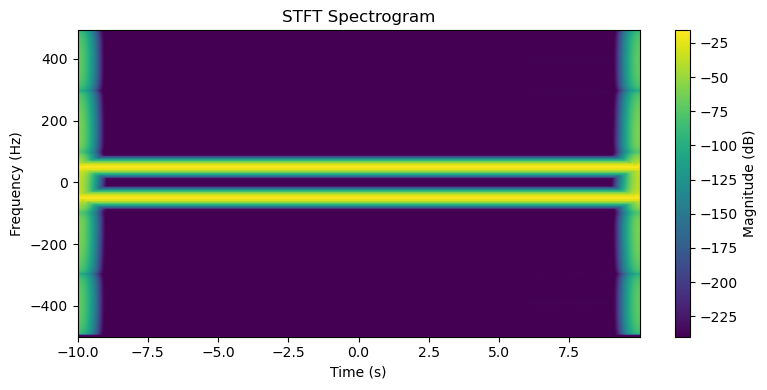

In [200]:
# checking Vs :
#c = np.abs(discrete_stft(f_samples, g_samples, delta_t, a, M)) # the most basic function itself
c = V[3]
import numpy as np
import matplotlib.pyplot as plt


# magnitude in dB
S = np.abs(c)
S_db = 20 * np.log10(S + 1e-12)   # add tiny floor to avoid log(0)

plt.figure(figsize=(8,4))
# imshow with origin='lower' so low freqs at bottom
plt.imshow(S_db,
           aspect='auto',
           origin='lower',
           extent=[stft_time[0], stft_time[-1], stft_frequency[0], stft_frequency[-1]])
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('STFT Spectrogram')
plt.tight_layout()
plt.show()


In [248]:
recon, J, J_hat = algorithm21(V, A)

 the shape of G_tilde is actually :: (4000, 129)


In [136]:


print("Number of True entries for J:", np.count_nonzero(J)) # ok so 



Number of True entries for J: 1292


tau= -9.9975 i= 0 x[i]= -9.9975 j= 0 t_axis[j]= -0.064 ic= 1999 x[ic]= -0.0025 jc= 64 t_axis[jc]= 0.0
tau= -9.9925 i= 1 x[i]= -9.9925 j= 0 t_axis[j]= -0.064 ic= 1999 x[ic]= -0.0025 jc= 64 t_axis[jc]= 0.0
tau= -9.9875 i= 2 x[i]= -9.9875 j= 0 t_axis[j]= -0.064 ic= 1999 x[ic]= -0.0025 jc= 64 t_axis[jc]= 0.0
tau= -9.9825 i= 3 x[i]= -9.9825 j= 0 t_axis[j]= -0.064 ic= 1999 x[ic]= -0.0025 jc= 64 t_axis[jc]= 0.0
tau= -9.977500000000001 i= 4 x[i]= -9.977500000000001 j= 0 t_axis[j]= -0.064 ic= 1999 x[ic]= -0.0025 jc= 64 t_axis[jc]= 0.0
tau= -9.9725 i= 5 x[i]= -9.9725 j= 0 t_axis[j]= -0.064 ic= 1999 x[ic]= -0.0025 jc= 64 t_axis[jc]= 0.0
tau= -9.9675 i= 6 x[i]= -9.9675 j= 0 t_axis[j]= -0.064 ic= 1999 x[ic]= -0.0025 jc= 64 t_axis[jc]= 0.0
tau= -9.9625 i= 7 x[i]= -9.9625 j= 0 t_axis[j]= -0.064 ic= 1999 x[ic]= -0.0025 jc= 64 t_axis[jc]= 0.0
tau= -9.9575 i= 8 x[i]= -9.9575 j= 0 t_axis[j]= -0.064 ic= 1999 x[ic]= -0.0025 jc= 64 t_axis[jc]= 0.0
tau= -9.9525 i= 9 x[i]= -9.9525 j= 0 t_axis[j]= -0.064 ic= 1

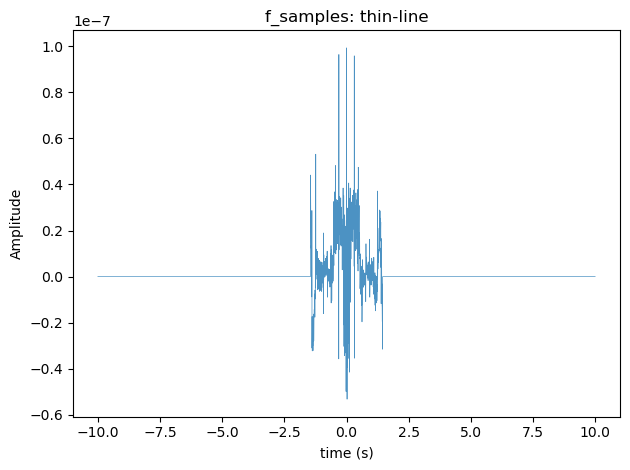

In [249]:

recon_vals = np.array([recon(τ, 0) for τ in x])

# Plot them side by side
import matplotlib.pyplot as plt


plt.plot(x, recon_vals,
         lw=0.5,           # very thin line
         color='tab:blue',
         alpha=0.8)    
plt.xlabel('time (s)')
plt.ylabel('Amplitude')
plt.title('f_samples: thin‐line')
plt.tight_layout()
plt.show()



 &emsp;&emsp;&emsp; $\text{1st note to myself}$: this pseudocode for some reason refers both to $φ_{j}({t})$ = $F_{a_{j}}({φ_{j}({t})})$ (so the function which has a rotated ambiguity of the gaussian's ambiguity - what I call rotated_diluted_gaussian) and $\phi_{j}(x,y) = F\bigl(\lvert V_{\phi}f\rvert^2\bigr)(x,y)$, who is the FT of STFT of those previously mentionned windows' , so I will call the latter G(x,y) like they do dude.....

 &emsp;&emsp;&emsp; $\text{2nd note to myself}$: we estimate $J(x,y)$ = $A_{f}(x,y)$ by lambda 1.3, however notice $ \overline{A_{g}(x,y)}$ = $A_{g}(x,y)$ for gaussian ambiugity functions : in fact, its all real values ! (remember: $A_{\phi_{j}}(x,y) \;=\; e^{-\frac{\pi}{2}(x^2 + y^2)}$)
 

 &emsp;&emsp;&emsp; $\text{3rd note to myself}$:
 

![title](ss4.jpeg)


 &emsp;&emsp;&emsp; $\text{4th note to myself}$: The STFT uses these sample conventions, and our ambiguity grid has to respect that:


 ![title](ss5.png)


